In [1]:
import csv
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.model_selection import train_test_split
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
import h5py as h5py
import pickle



%matplotlib inline

Using TensorFlow backend.


# Read the dataset

### Import the dataset
Before we can use the dataset,  we have to read it from the generated drives. For this purposes, a furnished dataset has been downloaded. UDacity provided this simple dataset, and it can be downloaded from [here](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip)

In [2]:
def import_dataset(data_source_path, csv_file_name):
    images = []
    steering_measurements = []
    throttle_measurements = []
    speed_measurements = []
    breaking_measurements = []
    with open(data_source_path+"./"+csv_file_name) as f:
        csv_lines = csv.reader(f)
        # skip first line
        next(csv_lines)
        for line in csv_lines:
            center, left, right, steering, throttle, br, speed = line
            steering = float(steering)
            for img_path, corrected_steering in zip([left, center, right], [steering+0.2, steering, steering-0.2]):
                image_path = img_path.strip()
                image = cv.imread(image_path)
                images.append(image)
                steering_measurements.append(corrected_steering)
                throttle_measurements.append(throttle)
                speed_measurements.append(speed)
                breaking_measurements.append(br)

    return np.array(images), np.array(steering_measurements), np.array(throttle_measurements), np.array(speed_measurements), np.array(breaking_measurements)

images, steering, throttle, speed, breaking = import_dataset('../collected_data', 'driving_log.csv')

### Analyse the images
Now that we have the images, lets see their shape and see some samples.

In [3]:
print(sum([1 for image in images if image is None]))
print(sum([1 for image in images if image is not None]))
print(steering.shape)
print(images.shape)

0
15174
(15174,)
(15174, 160, 320, 3)


Number of images: 15174
Shape of each image: (160, 320, 3)
random sample of steering angles: [-0.01408451, 0.01408451, -0.18122066000000001, 0.10610328000000001]
random sample of breaking: ['0', '0', '0', '0']
random sample of throttle: ['1', '1', '1', '1']
random sample of speed: ['30.19026', '30.19011', '30.19029', '30.18734']


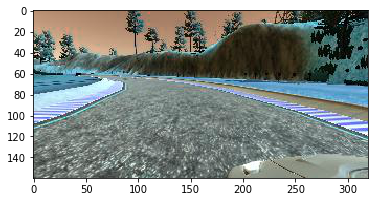

In [4]:
num_images, x_shape, y_shape, depth = images.shape
image_shape = (x_shape, y_shape, depth)
print("Number of images:", num_images)
print("Shape of each image:", image_shape)
print("random sample of steering angles:", random.sample(list(steering), 4))
print("random sample of breaking:", random.sample(list(breaking), 4))
print("random sample of throttle:", random.sample(list(throttle), 4))
print("random sample of speed:", random.sample(list(speed), 4))
plt.imshow(images[0])

# Data augmentation
Now that we have some data, we notice that the track is a closed loop, so the car only trains on turning left. Now, we can flip the images and the steering measurements.

In [5]:
print(steering.astype(np.float32)[:3])

[ 0.2  0.  -0.2]


In [6]:
flipped_images = np.array([np.fliplr(im) for im in images])
flipped_measurements = np.array([-1.*m for m in steering])

all_images = np.append(images, flipped_images, axis=0)
all_steering = np.append(steering, flipped_measurements, axis=0)

(15174, 160, 320, 3)
(15174,)
(15174, 160, 320, 3)
(30348, 160, 320, 3)
(15174,)
(30348,)
float64
float64
[-0.17183099  0.0075117   0.        ]
[ 0.17183099 -0.0075117  -0.        ]
-0.17183099
0.17183099
0.0075117
-0.0075117
0.0
-0.0


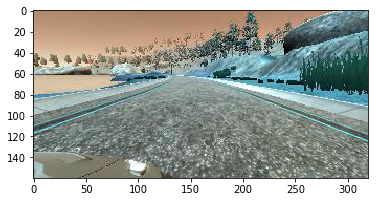

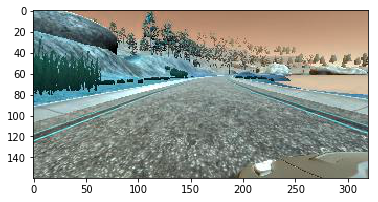

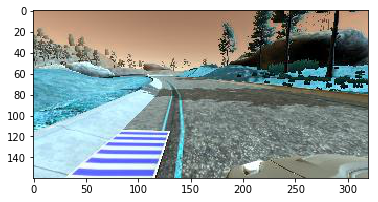

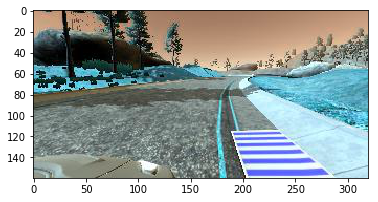

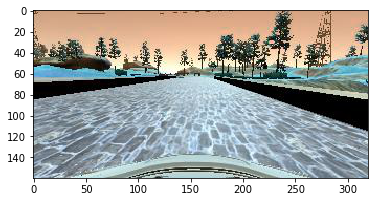

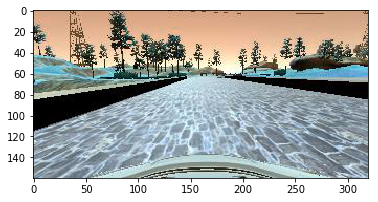

In [7]:
print(flipped_images.shape)
print(flipped_measurements.shape)
print(images.shape)
print(all_images.shape)
print(steering.shape)
print(all_steering.shape)
print(steering[0].dtype)
print(all_steering[0].dtype)
i = random.sample(range(len(steering)), 3)
print(steering[i])
print(flipped_measurements[i])
for ind in i:
    plt.figure()
    print(steering[ind])
    plt.imshow(images[ind])
    plt.figure()
    print(flipped_measurements[ind])
    plt.imshow(flipped_images[ind])

### Split the dataset into training and validation
Now that we have the whole dataset, we will save some of it and not train on as part of a validation set. We will save 1/4th of the dataset as validation.

In [8]:
X = all_images
# Y = np.column_stack((steering, throttle))
Y = all_steering
i = random.sample(range(500,700), 3)
print(i)
print("steering[:3]", steering[i])
print("throttle[:3]", throttle[i])
print("Y[:3]", Y[i])

shuffled_indecies = list(range(len(X)))
random.shuffle(shuffled_indecies)
print(int(len(shuffled_indecies)*0.33))
train_indecies = shuffled_indecies[int(len(shuffled_indecies)*0.33):]
test_indecies = shuffled_indecies[:int(len(shuffled_indecies)*0.33)]

# check
for i in train_indecies:
    if i in test_indecies:
        print(i,"is in test indecies")
        break
for i in test_indecies:
    if i in train_indecies:
        print(i,"is in train indecies")
        break
        
def save_data(filename, data):
    with open(filename, 'wb') as f:
        pickle.dump(data, f, protocol=4)
    print("done with saving to", filename)
        
save_data("y_train", Y[train_indecies])
save_data("X_train", X[train_indecies])

save_data("y_test", Y[test_indecies])
save_data("X_test", X[test_indecies])

[571, 684, 699]
steering[:3] [-0.0657277   0.19061033  0.19061033]
throttle[:3] ['1' '1' '1']
Y[:3] [-0.0657277   0.19061033  0.19061033]
10014
done with saving to y_train
done with saving to X_train
done with saving to y_test
done with saving to X_test


# Checkpoint - Load the data

In [ ]:
def load_data(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
y_train = load_data("y_train")
X_train = load_data("X_train")

y_test = load_data("y_test")
X_test = load_data("X_test")

# Import the VGG neural network

The first thing to do is load the pretrained VVG network and its weights. The first time we do this, keras will download the weights, so it may take a while.

After the weights are downloaded, we will then cache the output of the newtork for each of our images. If we run all our images through the network, we will have essentially transformed the images to a conceptual matrix that the VVG network was able to translate for us. This conceptual transfer is also the most time demanding part of the neural network, so we will have essentially cached all the training examples for a quick training time on the top layer that we will now create.

In [ ]:
def generator(samples_image_filenames, batch_size=32):
    num_samples = len(samples_image_filenames)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples_image_filenames)
        for offset in range(0, samples_image_filenames, batch_size):
            batch_samples = samples_image_filenames[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                name = './IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [ ]:
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.layers import Input
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.backend import tf as ktf
from keras.layers import Lambda
import scipy

def resize_image(image):
    return scipy.misc.imresize(image, (32,32))
#     return ktf.image.resize_images(images, (32, 32))

def normalize(image):
    return image/255.0 - 0.5

def train_model():
#     with open("bottleneck_features_and_labels.p", 'rb') as f:
#         data = pickle.load(f)
#         processed_images = data['features']
#         processed_steering = data['labels']
    
#     rescaled_x_train = np.array([resize_image(im) for im in X_train])
#     model = Sequential()
#     model.add(Conv2D(6, (5,5), activation='relu', input_shape=(32,32,3)))
#     print(model.layers[-1].output_shape)
#     model.add(MaxPooling2D())
#     print(model.layers[-1].output_shape)
#     model.add(Conv2D(16, (5,5), activation='relu'))
#     print(model.layers[-1].output_shape)
#     model.add(MaxPooling2D())
#     print(model.layers[-1].output_shape)
#     model.add(Flatten())
#     print(model.layers[-1].output_shape)
#     model.add(Dense(120))
#     print(model.layers[-1].output_shape)
#     model.add(Dense(80))
#     print(model.layers[-1].output_shape)
#     model.add(Dense(1))
#     print(model.layers[-1].output_shape)
#     model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    
#     datagen = ImageDataGenerator(preprocessing_function=resize_image)

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
#     datagen.fit(X_train)

    # fits the model on batches with real-time data augmentation:
#     model.fit_generator(
#         datagen.flow(X_train, y_train, batch_size=32, shuffle=True),
#                        steps_per_epoch=len(X_train) / 32, epochs=50, verbose=2)

#     model.fit(rescaled_x_train, y_train)
#     model.fit(rescaled_x_train, y_train, epochs=50, batch_size=32, verbose=2, validation_split=0.2, shuffle=True)
    
    model = Sequential()
    model.add(Lambda(normalize, input_shape=(160, 320, 3)))
    model.add(Cropping2D(cropping=((70,25), (0,0))))
    model.add(Conv2D(24, (5,5), strides=(2,2)))
    print(model.layers[-1].output_shape)
#     model.add(MaxPooling2D(pool_size=(5,5)))
#     print(model.layers[-1].output_shape)
    
    model.add(Conv2D(36, (5,5), strides=(2,2)))
    print(model.layers[-1].output_shape)
#     model.add(MaxPooling2D(pool_size=(5,5)))
#     print(model.layers[-1].output_shape)
    
    
    model.add(Conv2D(48, (5,5), strides=(2,2)))
    print(model.layers[-1].output_shape)
#     model.add(MaxPooling2D(pool_size=(3,3)))
#     print(model.layers[-1].output_shape)
    
    model.add(Conv2D(64, (3,3)))
    print(model.layers[-1].output_shape)
    
    
    model.add(Conv2D(64, (3,3)))
    print(model.layers[-1].output_shape)
#     model.add(MaxPooling2D(pool_size=(3,3)))
#     print(model.layers[-1].output_shape)
    
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2, validation_split=0.2, shuffle=True)
    model.save("model.h5")


    

train_model()

(None, 31, 158, 24)
(None, 14, 77, 36)
(None, 5, 37, 48)
(None, 3, 35, 64)
(None, 1, 33, 64)
Train on 16267 samples, validate on 4067 samples
Epoch 1/10
40s - loss: 0.0377 - val_loss: 0.0326
Epoch 2/10
36s - loss: 0.0320 - val_loss: 0.0387
Epoch 3/10
34s - loss: 0.0307 - val_loss: 0.0339
Epoch 4/10
32s - loss: 0.0302 - val_loss: 0.0356
Epoch 5/10
33s - loss: 0.0291 - val_loss: 0.0371
Epoch 6/10
33s - loss: 0.0281 - val_loss: 0.0352
Epoch 7/10
32s - loss: 0.0271 - val_loss: 0.0339
Epoch 8/10
32s - loss: 0.0261 - val_loss: 0.0333
Epoch 9/10


In [ ]:
with open("bottleneck_train_features_and_labels.p", 'rb') as f:
    data = pickle.load(f)
    processed_images = data['features']
    processed_steering = data['labels']
    

In [ ]:
print(processed_steering.shape)